# Customer retention

In [14]:
import pyod
from pyod.models.ecod import ECOD
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from kmodes.kprototypes import KPrototypes
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


## Create Synthetic Datasets

In [10]:
# Set seed for reproducibility
np.random.seed(37)

# Parameters
num_samples = 2000

cluster_centers = {
    ('Bogota', 6) : [700, 55000000, 20, 1.5],
    ('Bogota', 12) : [700,55000000, 20, 1.5],
    ('Medellin', 6) : [625, 47500000, 40, 1],
    ('Medellin', 12) : [625, 47500000, 40, 1],
    ('Cartagena', 6) : [550, 40000000, 30, .5],
    ('Cartagena', 12) : [550, 40000000, 30, .5]
}

# User IDs
user_id = np.arange(1, num_samples + 1)

#churn 
churn = np.random.choice([0, 1], size=num_samples, p=[0.8, 0.2])

# Gender: if churn is 1 make it 60% likely to be 1, and if churn is 0 make it 40% likely to be 1, so that churn is more likely for females
female = [np.random.choice([0, 1], p=[0.3, 0.7]) if c == 1 else np.random.choice([0, 1], p=[0.7, 0.3]) for c in churn]


# Create DataFrame
df = pd.DataFrame({
    'user_id': user_id,
    'churn': churn,
    'female': female
})


## Exploratory

In [6]:
df.head(n =10)

,user_id,churn,gender
0,1,1,female
1,2,0,male
2,3,0,female
3,4,0,male
4,5,0,male
5,6,0,female
6,7,0,male
7,8,0,female
8,9,0,female
9,10,0,male


In [11]:
df.corr()

,user_id,churn,female
user_id,1.000000,0.006670,0.008163
churn,0.006670,1.000000,0.306734
female,0.008163,0.306734,1.000000


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy



In [650]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()

,user_id,age,credit_score,income,number_of_installments,loan_orig_amt,installment_amt,installments_paid,on_time_payments,late_payments,number_past_loans,number_past_default,payment_date
count,2000.00,1999.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00
mean,1000.50,39.48,625.13,47555831.15,8.93,8028991.36,899281.57,3.90,3.11,0.79,2.41,0.47,14.64
std,577.49,9.63,63.53,6084873.07,3.00,5527780.76,513319.35,3.03,2.57,1.01,1.29,0.67,8.13
min,1.00,18.00,487.00,38334849.54,6.00,629611.81,104935.30,0.00,0.00,0.00,1.00,0.00,1.00
25%,500.75,32.00,562.00,40371596.18,6.00,4215474.98,543354.80,1.00,1.00,0.00,1.00,0.00,8.00
50%,1000.50,40.00,625.00,47542479.81,6.00,6612970.23,791878.15,3.00,3.00,0.00,2.00,0.00,15.00
75%,1500.25,47.00,688.00,54630752.17,12.00,10360975.52,1125873.41,5.00,5.00,1.00,4.00,1.00,22.00
max,2000.00,66.00,1200.00,56417082.63,12.00,62337579.45,5455774.04,11.00,11.00,6.00,5.00,3.00,28.00


In [651]:
print(df['location'].value_counts())
print(df['gender'].value_counts())

location
Medellin     691
Bogota       661
Cartagena    648
Name: count, dtype: int64
gender
female    1011
male       989
Name: count, dtype: int64


In [652]:
df.dtypes

user_id                     int64
age                       float64
gender                     object
location                   object
credit_score                int64
account_open                 bool
income                    float64
number_of_installments      int64
loan_orig_amt             float64
installment_amt           float64
installments_paid           int64
on_time_payments            int64
late_payments               int64
account_delq                 bool
number_past_loans           int64
number_past_default         int64
payment_date                int64
dtype: object

In [653]:
print(df.isnull().sum())

user_id                   0
age                       1
gender                    0
location                  0
credit_score              0
account_open              0
income                    0
number_of_installments    0
loan_orig_amt             0
installment_amt           0
installments_paid         0
on_time_payments          0
late_payments             0
account_delq              0
number_past_loans         0
number_past_default       0
payment_date              0
dtype: int64


### Visualizations

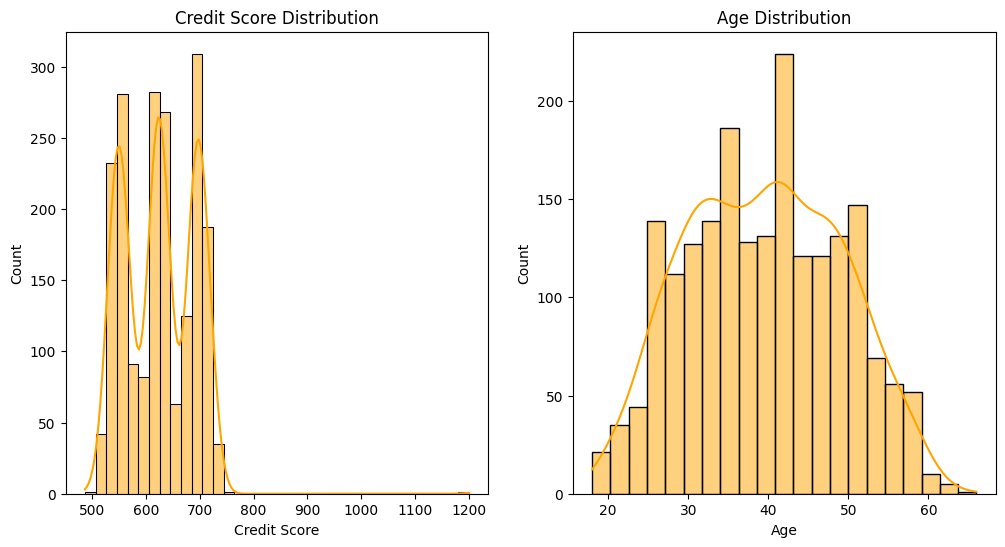

In [654]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df['credit_score'], kde=True, ax=ax[0], color = 'orange')
ax[0].set_title('Credit Score Distribution')
ax[0].set_xlabel('Credit Score')
sns.histplot(df['age'], kde=True, ax=ax[1], color = "orange")
ax[1].set_title('Age Distribution')
ax[1].set_xlabel('Age')
plt.show()

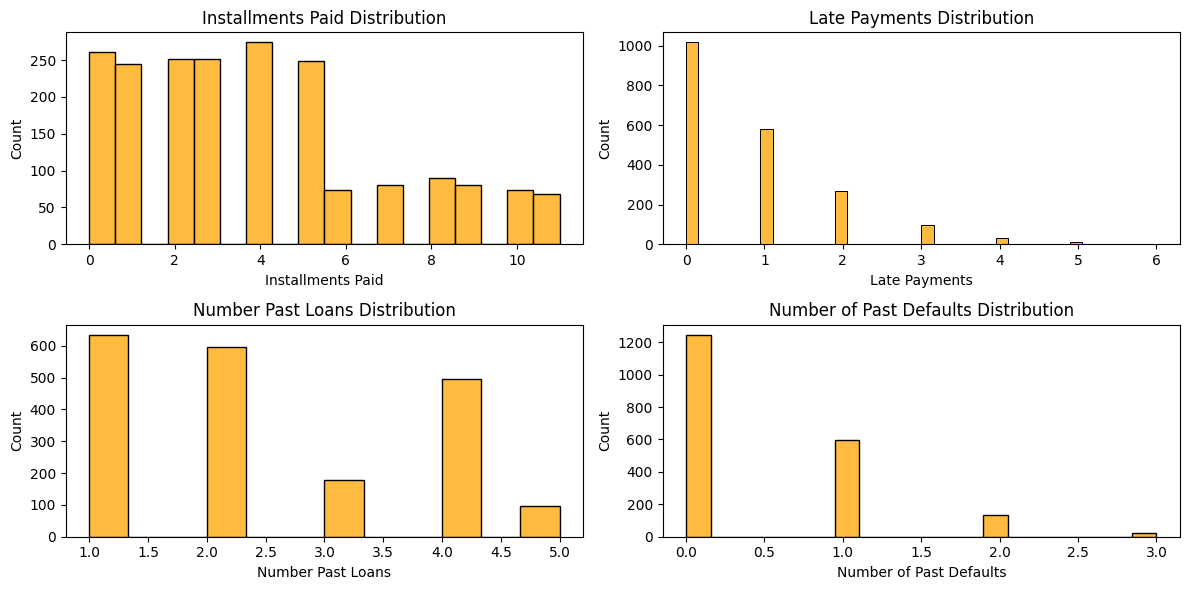

In [655]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
sns.histplot(df['installments_paid'], kde=False, ax=ax[0,0], color = "orange")
ax[0,0].set_title('Installments Paid Distribution')
ax[0,0].set_xlabel('Installments Paid')
sns.histplot(df['late_payments'], kde=False, ax=ax[0,1], color = "orange")   
ax[0,1].set_title('Late Payments Distribution')
ax[0,1].set_xlabel('Late Payments')
sns.histplot(df['number_past_loans'], kde=False, ax=ax[1,0], color = "orange")
ax[1,0].set_title('Number Past Loans Distribution')
ax[1,0].set_xlabel('Number Past Loans')
sns.histplot(df['number_past_default'], kde=False, ax=ax[1,1], color = "orange")
ax[1,1].set_title('Number of Past Defaults Distribution')
ax[1,1].set_xlabel('Number of Past Defaults')
plt.tight_layout()
plt.show()

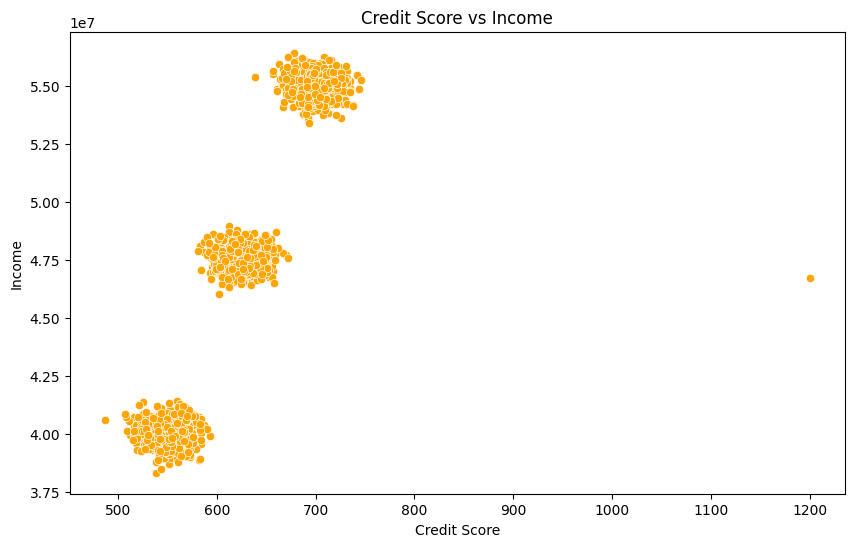

In [656]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='credit_score', y='income', data=df, color = "orange")
plt.title('Credit Score vs Income')
plt.xlabel('Credit Score')
plt.ylabel('Income')
plt.show()

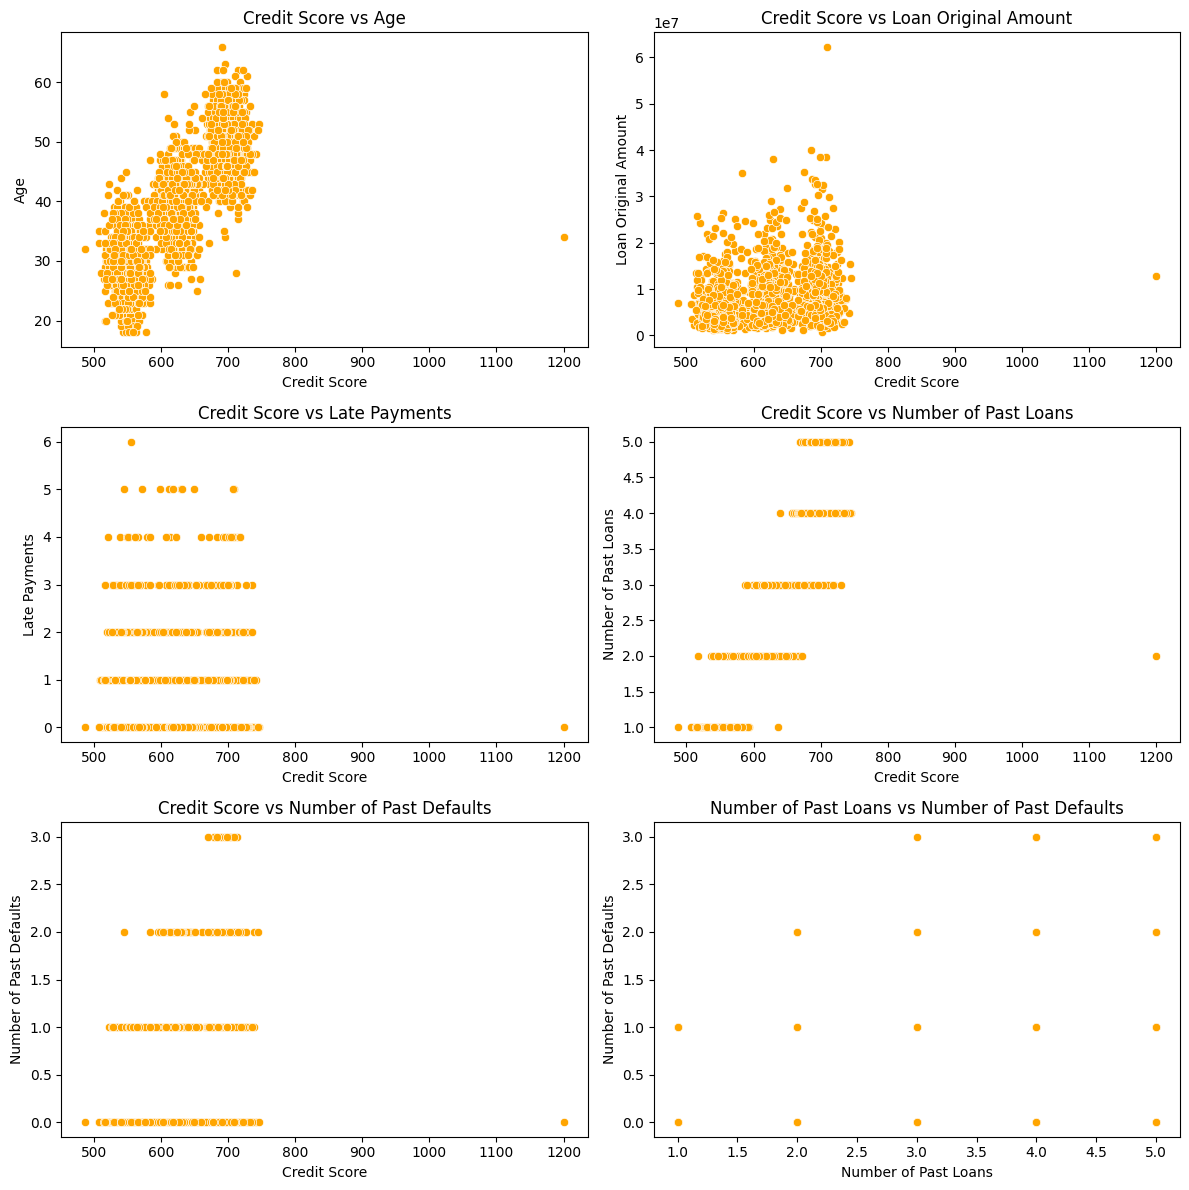

In [657]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
sns.scatterplot(x='credit_score', y='age', data=df, ax=ax[0,0], color = "orange")
ax[0,0].set_title('Credit Score vs Age')
ax[0,0].set_xlabel('Credit Score')
ax[0,0].set_ylabel('Age')
sns.scatterplot(x='credit_score', y='loan_orig_amt', data=df, ax=ax[0,1], color = "orange")
ax[0,1].set_title('Credit Score vs Loan Original Amount')
ax[0,1].set_xlabel('Credit Score')
ax[0,1].set_ylabel('Loan Original Amount')
sns.scatterplot(x='credit_score', y='late_payments', data=df, ax=ax[1,0], color = "orange")
ax[1,0].set_title('Credit Score vs Late Payments')
ax[1,0].set_xlabel('Credit Score')
ax[1,0].set_ylabel('Late Payments')
sns.scatterplot(x='credit_score', y='number_past_loans', data=df, ax=ax[1,1], color = "orange")
ax[1,1].set_title('Credit Score vs Number of Past Loans')
ax[1,1].set_xlabel('Credit Score')
ax[1,1].set_ylabel('Number of Past Loans')
sns.scatterplot(x='credit_score', y='number_past_default', data=df, ax=ax[2,0], color = "orange")
ax[2,0].set_title('Credit Score vs Number of Past Defaults')
ax[2,0].set_xlabel('Credit Score')
ax[2,0].set_ylabel('Number of Past Defaults')
sns.scatterplot(x='number_past_loans', y='number_past_default', data=df, ax=ax[2,1], color = "orange")
ax[2,1].set_title('Number of Past Loans vs Number of Past Defaults')
ax[2,1].set_xlabel('Number of Past Loans')
ax[2,1].set_ylabel('Number of Past Defaults')
plt.tight_layout()
plt.show()

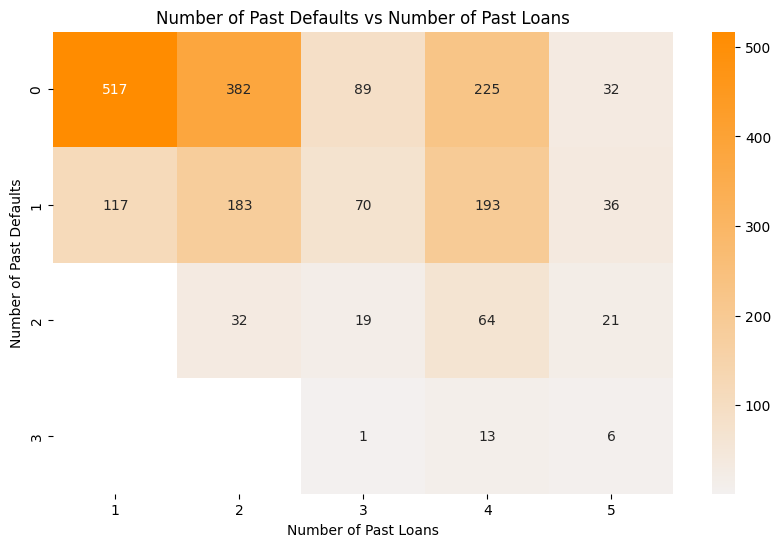

In [658]:
#heat map of number of past defaults and number of past loans flipped
plt.figure(figsize=(10, 6))
sns.heatmap(df.groupby(['number_past_default', 'number_past_loans']).size().unstack(), cmap=sns.light_palette("darkorange", as_cmap = True), annot=True, fmt='g')
plt.title('Number of Past Defaults vs Number of Past Loans')
plt.xlabel('Number of Past Loans')
plt.ylabel('Number of Past Defaults')
plt.show()

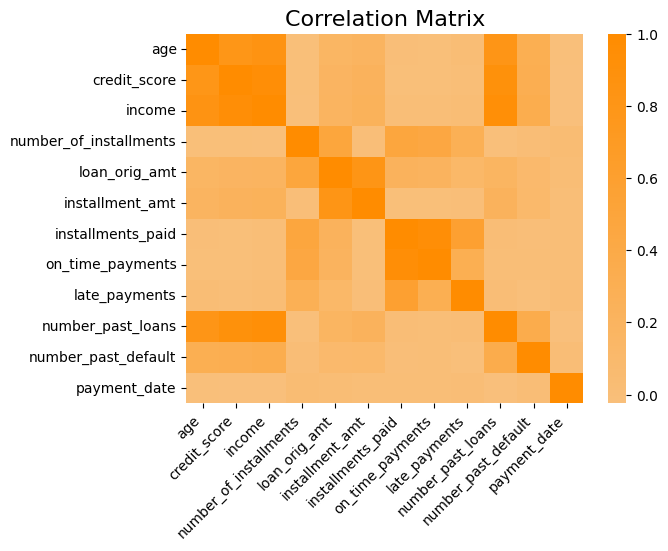

In [659]:
numerical = df.select_dtypes(include=[np.number]).drop(columns=['user_id'])
corr = numerical.corr()
ax = sns.heatmap(corr,  cmap=sns.light_palette("darkorange", as_cmap = True), center=0)
ax.set_title('Correlation Matrix', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## Data Cleaning

### Irrelevant Columns and Observations

Drop irrelevant observations and columns.

In [660]:
data = df.copy()

In [661]:
data = data[data['account_open'] == True].drop(columns=['payment_date', 'account_open', 'on_time_payments', 'installment_amt'])

### Missing Values

Investigate missing values 

Several options to handle  missings: if you have a lot of data and only a few missings, you can drop them, 
otherwise you can impute the missings in several ways including using the mean, median, or mode, you could draw a random value from the distribution, 
or you could use a machine learning model to predict the missing value. I am simply going to fill the missing values in age with the mean.

In [662]:
print(data.shape)
data = data.dropna()
print(data.shape)

(1896, 13)
(1895, 13)


### Outliers



In [663]:
numeric_vars = data.select_dtypes(include=[np.number]).columns
numeric_vars = numeric_vars.drop(['user_id'])
for var in numeric_vars:
    mean = data[var].mean()
    sd = data[var].std()
    data['outliers'] = (data[var] - mean).abs() > 3*sd
    print("The variable", var, "has" ,data['outliers'].sum(), "outlier(s).")

The variable age has 0 outlier(s).
The variable credit_score has 1 outlier(s).
The variable income has 0 outlier(s).
The variable number_of_installments has 0 outlier(s).
The variable loan_orig_amt has 35 outlier(s).
The variable installments_paid has 0 outlier(s).
The variable late_payments has 40 outlier(s).
The variable number_past_loans has 0 outlier(s).
The variable number_past_default has 19 outlier(s).


In [664]:
print("Data has", data.shape[0], "observations to begin.")
data['outliers'] = False
for var in numeric_vars:
    mean = data[var].mean()
    sd = data[var].std()
    data['outliers'] = data['outliers'] | ((data[var] - mean).abs() > 3*sd)
#drop outliers
data = data[data['outliers'] == False].drop(columns=['outliers'])
print("Data now has", data.shape[0], "observations after dropping the outliers .")

Data has 1895 observations to begin.
Data now has 1803 observations after dropping the outliers .


### Duplicates
We will want to drop duplicate values.

In [665]:
#Create a dataset of only the duplicates 
#count how many duplicates there are
duplicates = data[data.duplicated(keep=False)]
print(duplicates.shape[0], "duplicates found.")
duplicates

0 duplicates found.


,user_id,age,gender,location,credit_score,income,number_of_installments,loan_orig_amt,installments_paid,late_payments,account_delq,number_past_loans,number_past_default


In [666]:
print(data.shape)
data = data.drop_duplicates(subset=data.columns.difference(['user_id'])).reset_index(drop=True)
print(data.shape)

(1803, 13)
(1803, 13)


## Feature Engineering

In [667]:
# Standardize the data
numeric_vars = data.select_dtypes(include=[np.number]).columns
numeric_vars = numeric_vars.drop(['user_id'])
df_scaled = data.copy()
scaler = StandardScaler()
df_scaled[numeric_vars]  = scaler.fit_transform(df_scaled[numeric_vars])
df_scaled.head()

,user_id,age,gender,location,credit_score,income,number_of_installments,loan_orig_amt,installments_paid,late_payments,account_delq,number_past_loans,number_past_default
0,3,1.43,male,Bogota,1.80,1.24,1.06,0.00,1.45,2.63,False,1.27,0.91
1,4,-0.43,female,Cartagena,-1.15,-1.22,1.06,0.20,1.79,0.34,False,-1.08,0.91
2,5,0.71,male,Bogota,1.49,1.32,-0.95,-0.16,-0.60,0.34,True,1.27,0.91
3,6,0.39,female,Bogota,1.36,1.21,-0.95,-0.94,0.09,0.34,False,1.27,-0.71
4,7,0.29,male,Medellin,-0.13,0.15,1.06,0.52,0.09,1.48,False,-0.30,0.91


In [668]:
print(df_scaled['credit_score'].describe())
print(df_scaled['income'].describe())

count   1803.00
mean       0.00
std        1.00
min       -2.19
25%       -1.00
50%       -0.01
75%        1.01
max        1.97
Name: credit_score, dtype: float64
count   1803.00
mean      -0.00
std        1.00
min       -1.49
25%       -1.17
50%        0.02
75%        1.19
max        1.49
Name: income, dtype: float64


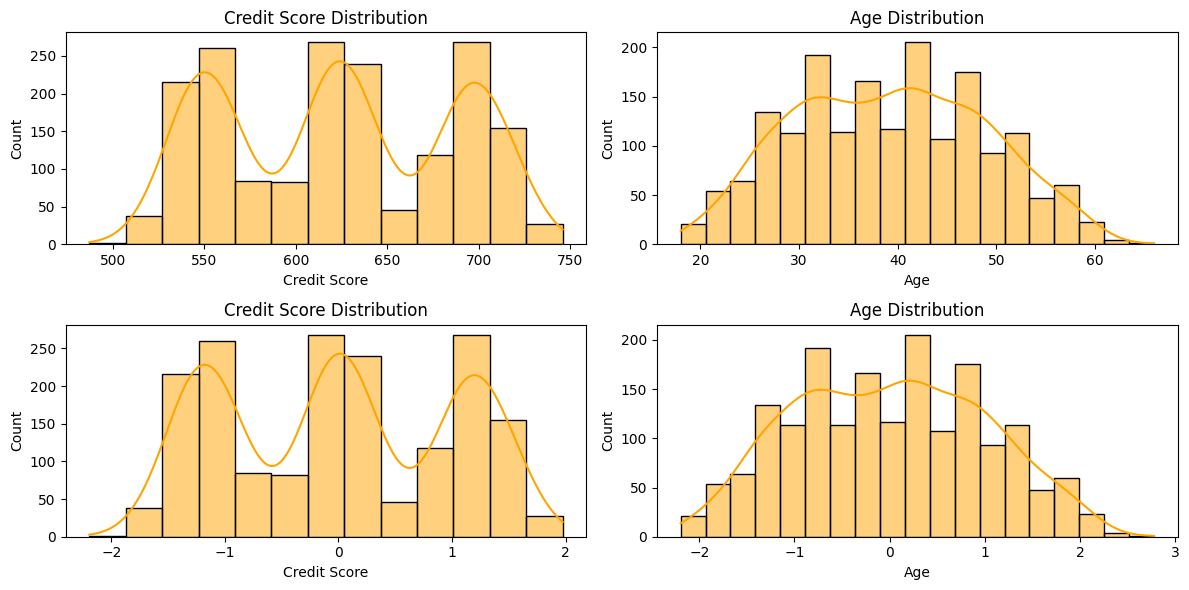

In [669]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
sns.histplot(data['credit_score'], kde=True, color = 'orange', ax=ax[0,0])
ax[0,0].set_title('Credit Score Distribution')
ax[0,0].set_xlabel('Credit Score')
sns.histplot(data['age'], kde=True, color = "orange", ax=ax[0,1])
ax[0,1].set_title('Age Distribution')
ax[0,1].set_xlabel('Age')
sns.histplot(df_scaled['credit_score'], kde=True, color = 'orange', ax=ax[1,0])
ax[1,0].set_title('Credit Score Distribution')
ax[1,0].set_xlabel('Credit Score')
sns.histplot(df_scaled['age'], kde=True, color = "orange",  ax=ax[1,1])
ax[1,1].set_title('Age Distribution')
ax[1,1].set_xlabel('Age')
plt.tight_layout()
plt.show()

Encode for K Means

In [670]:
for vars in ['account_delq']:
    df_scaled[vars] = df_scaled[vars].astype('object')

obj_cols = df_scaled.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False, drop='first')
one_hot_encoded = encoder.fit_transform(df_scaled[obj_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(obj_cols))

# Concatenate the one-hot encoded dataframe with the scaled dataframe
df_encoded = pd.concat([df_scaled, one_hot_df], axis=1)
print(df_encoded.shape)

# Drop the original categorical columns
df_encoded = df_encoded.drop(obj_cols, axis=1)

# Display the resulting dataframe
df_encoded.head()

(1803, 17)


,user_id,age,credit_score,income,number_of_installments,loan_orig_amt,installments_paid,late_payments,number_past_loans,number_past_default,gender_male,location_Cartagena,location_Medellin,account_delq_True
0,3,1.43,1.80,1.24,1.06,0.00,1.45,2.63,1.27,0.91,1.00,0.00,0.00,0.00
1,4,-0.43,-1.15,-1.22,1.06,0.20,1.79,0.34,-1.08,0.91,0.00,1.00,0.00,0.00
2,5,0.71,1.49,1.32,-0.95,-0.16,-0.60,0.34,1.27,0.91,1.00,0.00,0.00,1.00
3,6,0.39,1.36,1.21,-0.95,-0.94,0.09,0.34,1.27,-0.71,0.00,0.00,0.00,0.00
4,7,0.29,-0.13,0.15,1.06,0.52,0.09,1.48,-0.30,0.91,1.00,0.00,1.00,0.00


In [671]:
#drop the user_id column
data_for_clustering_means = df_encoded.drop(columns=['user_id'])

## Logistic Regression

### Basic Example

In [ ]:
clf = LogisticRegression(random_state=0).fit(data_for_clustering_means, df_encoded['churn'])
clf.predict(data_for_clustering_means)
clf.predict_proba(data_for_clustering_means)
clf.score(data_for_clustering_means, df_encoded['churn'])

### Supervised Learning Example

#### Training and Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_for_clustering_means, df_encoded['churn'], test_size=0.2, random_state=0)
print('Original data shape is', data_for_clustering_means.shape, 'X training shape is', X_train.shape, 'y training shape is', y_train.shape, 'X test shape is', X_test.shape, 'y test shape is', y_test.shape)

In [ ]:
clf_train = LogisticRegression(random_state=0).fit(X_train, y_train)
clf_train.predict(X_test)
clf_train.predict_proba(X_test)
clf_train.score(X_test, y_test)

#### Cross Validation

In [ ]:
scores = cross_val_score(clf, data_for_clustering_means, df_encoded['churn'], cv=5)
print('Cross-validation scores:', scores)

### Implementation

In [ ]:
clf = LogisticRegressionCV(cv=5, random_state=0, max_iter=1000).fit(data_for_clustering_means, df_encoded['churn'])
print("The accuracy of the model is", clf.score(data_for_clustering_means, df_encoded['churn']))